# Preliminaries: imports, start H2O, load data

In [1]:
import sklearn
import pandas as pd
import numpy as np
import shap
import h2o
from h2o.automl import H2OAutoML

In [2]:
df = pd.read_csv('C:/Users/Karti/NEU/data/insurance.csv')

In [3]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [4]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,4 hours 20 mins
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.0.2
H2O_cluster_version_age:,22 days
H2O_cluster_name:,H2O_from_python_Karti_c6zhqp
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,10.17 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


In [5]:
data_path = 'C:/Users/Karti/NEU/data/insurance.csv'
h2o_df = h2o.import_file(data_path)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [6]:
splits = h2o_df.split_frame(ratios=[0.8],seed=1)
train = splits[0]
test = splits[1]

In [7]:
y = "charges" 
x = h2o_df.columns 
x.remove(y)

# Run h2o AutoML

In [8]:
aml = H2OAutoML(max_runtime_secs=180, seed=1)
aml.train(x=x,y=y, training_frame=train)

AutoML progress: |█
16:09:28.212: AutoML: XGBoost is not available; skipping it.

███████████████████████████████████████████████████████| 100%


In [9]:
lb = aml.leaderboard
lb.head()

model_id,mean_residual_deviance,rmse,mse,mae,rmsle
StackedEnsemble_AllModels_AutoML_20200521_160928,1.95178e+07,4417.89,1.95178e+07,2393.51,0.404861
StackedEnsemble_BestOfFamily_AutoML_20200521_160928,1.96316e+07,4430.76,1.96316e+07,2415.14,0.411037
GBM_grid__1_AutoML_20200521_160928_model_1,1.97322e+07,4442.1,1.97322e+07,2432.87,0.417863
GBM_grid__1_AutoML_20200521_160928_model_4,1.99914e+07,4471.17,1.99914e+07,2520.75,0.415081
GBM_grid__1_AutoML_20200521_160928_model_8,2.00474e+07,4477.43,2.00474e+07,2442.82,0.421568
GBM_grid__1_AutoML_20200521_160928_model_10,2.03408e+07,4510.08,2.03408e+07,2510.67,0.440234
GBM_grid__1_AutoML_20200521_160928_model_46,2.05227e+07,4530.2,2.05227e+07,2510.88,0.460756
GBM_grid__1_AutoML_20200521_160928_model_29,2.06272e+07,4541.71,2.06272e+07,2607.01,0.450299
GBM_grid__1_AutoML_20200521_160928_model_43,2.07472e+07,4554.91,2.07472e+07,2616.74,0.449175
GBM_grid__1_AutoML_20200521_160928_model_14,2.10932e+07,4592.73,2.10932e+07,2616.26,0.452068


In [10]:
# Get model ids for all models in the AutoML Leaderboard
model_ids = list(aml.leaderboard['model_id'].as_data_frame().iloc[:,0])
# Get the "All Models" Stacked Ensemble model
se = h2o.get_model([mid for mid in model_ids if "StackedEnsemble_AllModels" in mid][0])
# Get the Stacked Ensemble metalearner model
metalearner = h2o.get_model(se.metalearner()['name'])

In [11]:
pred = aml.predict(test)
pred.head()

stackedensemble prediction progress: |████████████████████████████████████| 100%


predict
6208.28
13734.7
14604.9
2795.44
49550.8
6137.1
48559.4
5504.66
17255.8
12801


In [12]:
lb = h2o.automl.get_leaderboard(aml, extra_columns = 'ALL')
lb

model_id,mean_residual_deviance,rmse,mse,mae,rmsle,training_time_ms,predict_time_per_row_ms
StackedEnsemble_AllModels_AutoML_20200521_160928,1.95178e+07,4417.89,1.95178e+07,2393.51,0.404861,280,0.159238
StackedEnsemble_BestOfFamily_AutoML_20200521_160928,1.96316e+07,4430.76,1.96316e+07,2415.14,0.411037,152,0.046001
GBM_grid__1_AutoML_20200521_160928_model_1,1.97322e+07,4442.1,1.97322e+07,2432.87,0.417863,91,0.014962
GBM_grid__1_AutoML_20200521_160928_model_4,1.99914e+07,4471.17,1.99914e+07,2520.75,0.415081,212,0.014825
GBM_grid__1_AutoML_20200521_160928_model_8,2.00474e+07,4477.43,2.00474e+07,2442.82,0.421568,118,0.010709
GBM_grid__1_AutoML_20200521_160928_model_10,2.03408e+07,4510.08,2.03408e+07,2510.67,0.440234,97,0.017277
GBM_grid__1_AutoML_20200521_160928_model_46,2.05227e+07,4530.2,2.05227e+07,2510.88,0.460756,156,0.017223
GBM_grid__1_AutoML_20200521_160928_model_29,2.06272e+07,4541.71,2.06272e+07,2607.01,0.450299,151,0.020761
GBM_grid__1_AutoML_20200521_160928_model_43,2.07472e+07,4554.91,2.07472e+07,2616.74,0.449175,231,0.029505
GBM_grid__1_AutoML_20200521_160928_model_14,2.10932e+07,4592.73,2.10932e+07,2616.26,0.452068,98,0.016189


# View 'Black box' model

In [13]:
#extract the best model in leaderboard list
bst_model = aml.leader
bst_model

Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_AllModels_AutoML_20200521_160928

No model summary for this model

ModelMetricsRegressionGLM: stackedensemble
** Reported on train data. **

MSE: 15666345.162742808
RMSE: 3958.0734155322093
MAE: 2205.8215304305054
RMSLE: 0.360771370206251
R^2: 0.8881586253169274
Mean Residual Deviance: 15666345.162742808
Null degrees of freedom: 1065
Residual degrees of freedom: 1057
Null deviance: 149321518899.49396
Residual deviance: 16700323943.483833
AIC: 20705.62597511269

ModelMetricsRegressionGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 19517768.178981844
RMSE: 4417.89182517882
MAE: 2393.5148730881783
RMSLE: 0.4048608000034505
R^2: 0.8606634795029184
Mean Residual Deviance: 19517768.178981844
Null degrees of freedom: 1065
Residual degrees of freedom: 1053
Null deviance: 149600136035.9225
Residual deviance: 20805940878.794647
AIC: 20947.94391273476


# Use a decision tree surrogate to generate explanations of the "black box" model
#### First bind the "black box" model predictions onto the training frame

In [14]:
preds = bst_model.predict(h2o_df)
preds.columns = ['predicted_charges']
frame_yhat = h2o_df.cbind(preds)

stackedensemble prediction progress: |████████████████████████████████████| 100%


#### Train decision tree surrogate model

In [16]:
from h2o.estimators.gbm import H2OGradientBoostingEstimator


yhat = 'predicted_charges'
model_id = 'dt_surrogate_mojo'

# train single tree surrogate model
surrogate = H2OGradientBoostingEstimator(ntrees=1,
                                         sample_rate=1,
                                         col_sample_rate=1,
                                         max_depth=3,
                                         seed=12345,
                                         model_id=model_id)

_ = surrogate.train(x=x, y=yhat, training_frame=frame_yhat)

# persist MOJO (compiled, representation of trained model)
# from which to generate plot of surrogate
mojo_path = surrogate.download_mojo(path='.')

print(surrogate)
print('Generated MOJO path:\n', mojo_path)

gbm Model Build progress: |███████████████████████████████████████████████| 100%
Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  dt_surrogate_mojo


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,1.0,1.0,158.0,3.0,3.0,3.0,8.0,8.0,8.0




ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 105831136.87624091
RMSE: 10287.426154108758
MAE: 7369.9151155161035
RMSLE: 0.7463192597253426
Mean Residual Deviance: 105831136.87624091

Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance
0,,2020-05-21 16:26:21,0.002 sec,0.0,11401.134471,8162.155637,1.299859e+08
1,,2020-05-21 16:26:21,0.009 sec,1.0,10287.426154,7369.915116,1.058311e+08



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,smoker,1.260001e+11,1.000000,0.740741
1,bmi,2.622015e+10,0.208096,0.154145
2,age,1.787988e+10,0.141904,0.105114
3,sex,0.000000e+00,0.000000,0.000000
4,children,0.000000e+00,0.000000,0.000000
5,region,0.000000e+00,0.000000,0.000000



Generated MOJO path:
 C:\Users\Karti\dt_surrogate_mojo.zip


# Generate GraphViz representation of MOJO

In [17]:
from h2o.backend import H2OLocalServer
# for calling external processes
import os
import re
import subprocess
from subprocess import CalledProcessError
import time



details = False # print more info on tree, details = True
title = 'Medical Charges Tree Surrogate'

hs = H2OLocalServer()
h2o_jar_path = hs._find_jar()
print('Discovered H2O jar path:\n', h2o_jar_path)

gv_file_name = model_id + '.gv'
gv_args = str('-cp ' + h2o_jar_path +
              ' hex.genmodel.tools.PrintMojo --tree 0 -i '
              + mojo_path + ' -o').split()
gv_args.insert(0, 'java')
gv_args.append(gv_file_name)

if details:
    gv_args.append('--detail')

if title is not None:
    gv_args = gv_args + ['--title', title]
    
print()
print('Calling external process ...')
print(' '.join(gv_args))
    
_ = subprocess.call(gv_args)

Discovered H2O jar path:
 C:\Users\Karti\Anaconda3\lib\site-packages\h2o\backend\bin\h2o.jar

Calling external process ...
java -cp C:\Users\Karti\Anaconda3\lib\site-packages\h2o\backend\bin\h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i C:\Users\Karti\dt_surrogate_mojo.zip -o dt_surrogate_mojo.gv --title Medical Charges Tree Surrogate


# Generate PNG from GraphViz representation

In [18]:
png_file_name = model_id + '.png'
png_args = str('dot -Tpng ' + gv_file_name + ' -o ' + png_file_name)
png_args = png_args.split()

print('Calling external process ...')
print(' '.join(png_args))

_ = subprocess.call(png_args)

Calling external process ...
dot -Tpng dt_surrogate_mojo.gv -o dt_surrogate_mojo.png


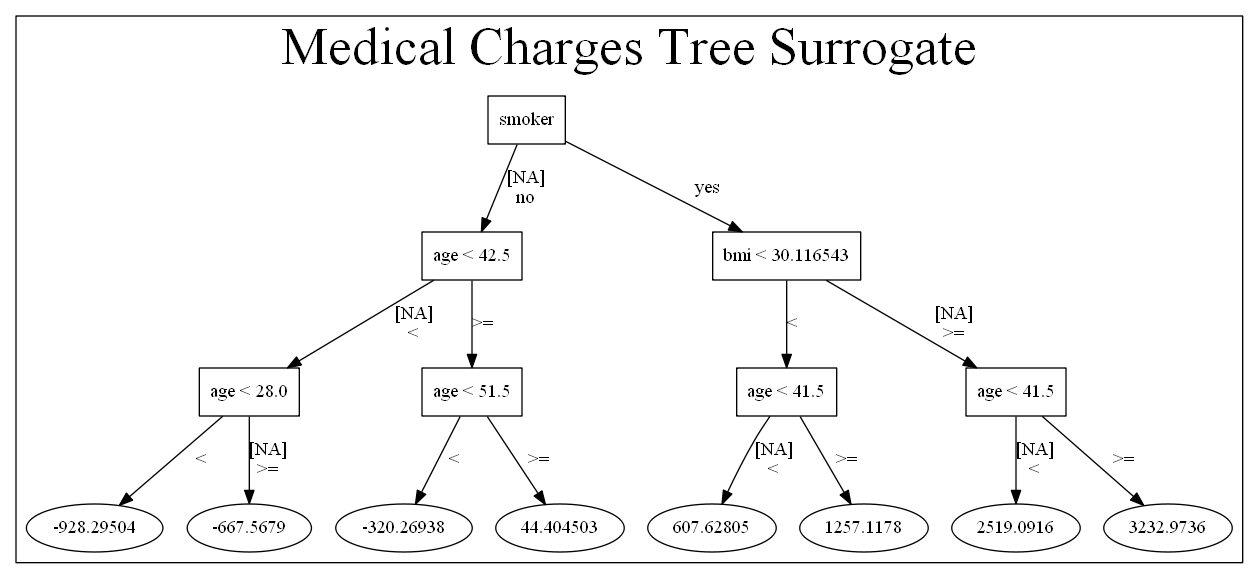

In [19]:
# for in-notebook display 
from IPython.display import Image
from IPython.display import display

display(Image((png_file_name)))

In [ ]:
# shutdown h2o
h2o.cluster().shutdown(prompt=True)